In [ ]:
# -*- coding: utf-8 -*-
# @Author : Xingmin Liu
# @Time : 2023.11.20

### LightGBM

In [ ]:
import pandas as pd
from utils import noise
from utils import repeat
from utils import symmetric_sift
from utils import naturalF
from utils import merge
from skimage.filters import gabor
from skimage.filters import threshold_otsu

image_folder = './dataset/train/fake/'
noise_csv = noise.process_directory(image_folder, './dataset/train/fake/__train_fake_noise_new.csv')
selfRrelevance_csv = repeat.process_images_in_folder(image_folder, './dataset/train/fake/__train_fake_selfRrelevance_new.csv')
symmetry_csv = symmetric_sift.process_images(image_folder, './dataset/train/fake/__train_fake_symmetry_new.csv')
natural_csv = naturalF.process_images_in_folder(image_folder, './dataset/train/fake/__train_fake_natural_new.csv')

tabel1_path = './dataset/train/fake/__train_fake_noise_new.csv'
tabel2_path = './dataset/train/fake/__train_fake_selfRrelevance_new.csv'
tabel3_path = './dataset/train/fake/__train_fake_symmetry_new.csv'
tabel4_path = './dataset/train/fake/__train_fake_natural_new.csv'
merge_tabel = merge.merge_tables_and_save(tabel1_path, tabel2_path, tabel3_path, tabel4_path, './model/input_files/__train_fake_new.csv')


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 读取数据
df = pd.read_csv('./model/input_files/_train_final.csv')

# 将定类变量转换为数字
labelEncoder = LabelEncoder()
df['is_noisy'] = labelEncoder.fit_transform(df['is_noisy'])
df['has_repeating_patterns'] = labelEncoder.fit_transform(df['has_repeating_patterns'])
df['is_symmetric'] = labelEncoder.fit_transform(df['is_symmetric'])

# 定义自变量和因变量
X = df.drop(['image_path', 'label'], axis=1)
Y = df['label']

# 划分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Feature importances: [  1 444   3  27  83 455 349 423 283 315 284 333]


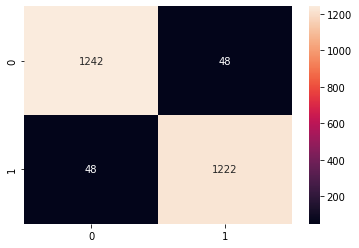

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1290
           1       0.96      0.96      0.96      1270

    accuracy                           0.96      2560
   macro avg       0.96      0.96      0.96      2560
weighted avg       0.96      0.96      0.96      2560

Accuracy: 0.9625


In [2]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 创建 LightGBM 数据集
train_data = lgb.Dataset(X_train, label=Y_train)

# 定义参数
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# 训练模型
model = lgb.train(params, train_data, num_boost_round=100)

# 预测测试集
Y_pred = model.predict(X_test)
Y_pred = [1 if pred > 0.5 else 0 for pred in Y_pred]

# 输出特征重要性
print("Feature importances:", model.feature_importance())

# 输出混淆矩阵热力图
conf_matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.show()

# 输出准确率，召回率，精确率，F1
print(classification_report(Y_test, Y_pred))

# 输出准确率
print("Accuracy:", accuracy_score(Y_test, Y_pred))

### LightGBM 融合 ResNet50

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1925
[LightGBM] [Info] Number of data points in the train set: 10240, number of used features: 12
[LightGBM] [Info] Start training from score 0.500977


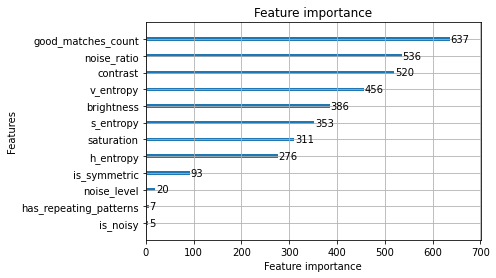

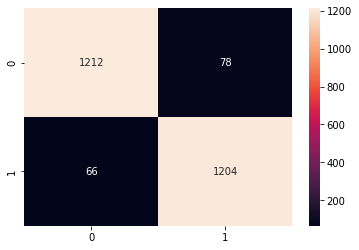

Accuracy: 0.94375
Precision: 0.9391575663026521
Recall: 0.9480314960629921
F1 Score: 0.9435736677115988


In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, plot_importance

# 1. 读取数据
df = pd.read_csv('./model/input_files/_train_final.csv')

# 2. 将布尔值转换为二进制值
for column in ['is_noisy', 'has_repeating_patterns', 'is_symmetric']:
    df[column] = df[column].astype(int)

# 3. 指定自变量和因变量
X = df.drop(['image_path', 'label'], axis=1)
y = df['label']

# 4. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. 训练模型
model = LGBMRegressor(
    num_leaves=25,          # 叶子节点数
    max_depth=-1,           # 树的最大深度，-1 意味着没有限制
    learning_rate=0.001,    # 学习率
    n_estimators=150,       # 模型中的树的数量
    min_child_samples=50,   # 叶子节点最小的样本数量
    reg_alpha=0.0,          # L1 正则化项的系数
    reg_lambda=0.0,         # L2 正则化项的系数
    subsample=1.0,          # 建立每棵树时使用的样本的比例
    colsample_bytree=0.7    # 建立每棵树时使用的特征的比例
)
model.fit(X_train, y_train)

# 6. 预测
y_pred = model.predict(X_test)

# 7. 将预测结果转换为两个类别并保存在新的变量中
threshold = 0.5
y_pred_class = [1 if pred > threshold else 0 for pred in y_pred]

# 8. 输出特征重要性
plot_importance(model)
plt.show()

# 9. 输出混淆矩阵热力图
cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d')  # 'd' 表示将数值显示为整数
plt.show()

# 10. 输出准确率，召回率，精确率，F1
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [38]:
def make_predictions_and_save(model, threshold=0.5):
    # 读取新的数据集
    df_new = pd.read_csv('./predict/files/_test_merge.csv')

    # 指定自变量
    X_new = df_new.drop(['image_path'], axis=1)

    # 使用模型进行预测
    y_pred = model.predict(X_new)

    # 将预测结果转换为两个类别
    y_pred_class = [1 if pred > threshold else 0 for pred in y_pred]

    # 将预测结果添加到数据集中
    df_new['y_pred'] = y_pred
    df_new['y_pred_class'] = y_pred_class

    # 保存到新的CSV文件
    df_new.to_csv('output_LGBM.csv', index=False)

# 使用训练过的模型进行预测并保存结果
make_predictions_and_save(model)

In [23]:
from utils import noise
from utils import repeat
from utils import symmetric_sift
from utils import naturalF
from utils import merge
from skimage.filters import gabor
from skimage.filters import threshold_otsu

image_folder = './dataset/test/fake/'
noise_csv = noise.process_directory(image_folder, './predict/files/_test_noise.csv')
selfRrelevance_csv = repeat.process_images_in_folder(image_folder, './predict/files/_test_repeat.csv')
symmetry_csv = symmetric_sift.process_images(image_folder, './predict/files/_test_symmetric.csv')
natural_csv = naturalF.process_images_in_folder(image_folder, './predict/files/_test_natural.csv')

tabel1_path = './predict/files/_test_noise.csv'
tabel2_path = './predict/files/_test_repeat.csv'
tabel3_path = './predict/files/_test_symmetric.csv'
tabel4_path = './predict/files/_test_natural.csv'
merge_file = './predict/files/_test_merge.csv'
merge_tabel = merge.merge_tables_and_save(tabel1_path, tabel2_path, tabel3_path, tabel4_path, merge_file)

True
True
True
True
False
True
True
True


Processing images: 100%|██████████| 8/8 [00:00<00:00, 18.69it/s]
